In [1474]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm


### Import both GMD and weekly estimated cases

In [1475]:
all_state_mob_data = pd.read_csv("data/all_state_mob_data.csv")
weekly_est_cases_deaths = pd.read_csv("data/weekly_est_cases_deaths.csv")

all_state_mob_data['date'] = pd.to_datetime(all_state_mob_data['date'])
weekly_est_cases_deaths['date'] = pd.to_datetime(weekly_est_cases_deaths['date'])

In [1476]:
weekly_est_cases_deaths.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2154 entries, 0 to 2153
Data columns (total 25 columns):
state                       2154 non-null object
date                        2154 non-null datetime64[ns]
new_cases_jhu               2154 non-null int64
new_deaths_jhu              2154 non-null int64
Excess Lower Estimate       2103 non-null float64
Excess Higher Estimate      2103 non-null float64
mid_point_xs_deaths         2103 non-null float64
corr_new_deaths             2154 non-null float64
est_inf                     2052 non-null float64
pro_chg_est_inf             2017 non-null float64
mobile_infectious           2035 non-null float64
phi                         2035 non-null float64
population                  2154 non-null int64
est_inf_per_100k            2052 non-null float64
new_cases_per_100k          2154 non-null float64
state_id                    2154 non-null object
rho                         2154 non-null float64
weekly_exposures            2154 non-null fl

### Select only the change from baseline data from the Google Mobility Data and then sum by week

In [1477]:
all_state_mob_data['date'] = pd.to_datetime(all_state_mob_data['date'])
mob_data = all_state_mob_data.iloc[:,0:8].copy()
name_change_dict = {
    'retail_and_recreation_percent_change_from_baseline':'retail_weekly_change',
    'grocery_and_pharmacy_percent_change_from_baseline':'grocery_weekly_change',
    'parks_percent_change_from_baseline':'parks_weekly_change',
    'transit_stations_percent_change_from_baseline':'transit_weekly_change',
    'workplaces_percent_change_from_baseline':'work_weekly_change',
    'residential_percent_change_from_baseline':'home_weekly_change'
}
weekly_mobility_data = mob_data.groupby('sub_region_1').resample('W-SAT', on='date').sum()
weekly_mobility_data.rename(columns=name_change_dict, inplace=True)
weekly_mobility_data.reset_index(inplace=True)

In [1478]:
weekly_mobility_data.head()

,sub_region_1,date,retail_weekly_change,grocery_weekly_change,parks_weekly_change,transit_weekly_change,work_weekly_change,home_weekly_change
0,Alabama,2020-02-15,5.0,2.0,39.0,7.0,2.0,-1.0
1,Alabama,2020-02-22,4.0,-6.0,38.0,34.0,-9.0,9.0
2,Alabama,2020-02-29,63.0,29.0,134.0,75.0,7.0,-4.0
3,Alabama,2020-03-07,79.0,47.0,168.0,65.0,19.0,-4.0
4,Alabama,2020-03-14,59.0,114.0,272.0,67.0,10.0,-4.0


### Select only state, date, estimated infections per 100k population, and phi from esimated infections data by state

In [1752]:
input_state = 'Wisconsin'

In [1753]:
# limit the date range to a 'no-earlier-than' date (filter is applied directly below and for the GMD specified state/date range filter)
date_selector = pd.to_datetime('2020-02-28')

In [1754]:
weekly_for_state = weekly_est_cases_deaths[(weekly_est_cases_deaths['state'] == input_state) & (weekly_est_cases_deaths['date'] > date_selector)].copy()
weekly_for_state = weekly_for_state[['state','date','est_inf_per_100k','phi']]

### Select GMD for the specified state

In [1755]:
weekly_mobility_data_for_state = weekly_mobility_data[(weekly_mobility_data['sub_region_1'] == input_state)& (weekly_mobility_data['date'] > date_selector)].copy()
del weekly_mobility_data_for_state['sub_region_1']

### Merge the two data sets

In [1756]:
df_gmd_and_infections = pd.merge(weekly_for_state, weekly_mobility_data_for_state, how='inner', left_on=['date'], right_on=['date'])

In [1757]:
cols_order_change = ['date',
 'retail_weekly_change',
 'grocery_weekly_change',
 'parks_weekly_change',
 'transit_weekly_change',
 'work_weekly_change',
 'home_weekly_change',
'phi',
'est_inf_per_100k',]

In [1758]:
df_gmd_and_infections = df_gmd_and_infections[cols_order_change]
df_gmd_and_infections.dropna(inplace=True)

## Generate the X training set for the linear regression model

In [1759]:
X = df_gmd_and_infections[[
 'retail_weekly_change',
 'grocery_weekly_change',
 'parks_weekly_change',
 'transit_weekly_change',
 'work_weekly_change',
 'home_weekly_change',
'phi']]
y = df_gmd_and_infections['est_inf_per_100k']

#### Manual method for generating a scaled X set - ignore because now I've setup the pipeline

In [1760]:
df_gmd_and_infections_no_date = df_gmd_and_infections.copy()
del df_gmd_and_infections_no_date['date']

In [1761]:
df_gmd_and_infections_no_date.head(3)

,retail_weekly_change,grocery_weekly_change,parks_weekly_change,transit_weekly_change,work_weekly_change,home_weekly_change,phi,est_inf_per_100k
0,32.0,94.0,211.0,20.0,11.0,5.0,0.000101,108.597195
1,-196.0,45.0,108.0,-138.0,-146.0,77.0,0.001086,290.445542
2,-345.0,-139.0,159.0,-269.0,-266.0,125.0,0.002904,232.359869


### Manual multivariate linear regression
modified from <html>https://medium.com/we-are-orb/multivariate-linear-regression-in-python-without-scikit-learn-7091b1d45905</html>

In [1762]:
# normalize the features using mean normalization
df_gmd_and_infections_no_date_normalized = (df_gmd_and_infections_no_date - df_gmd_and_infections_no_date.mean())/df_gmd_and_infections_no_date.std()
df_gmd_and_infections_no_date_normalized.head(3)

,retail_weekly_change,grocery_weekly_change,parks_weekly_change,transit_weekly_change,work_weekly_change,home_weekly_change,phi,est_inf_per_100k
0,1.537763,1.498927,-1.141712,1.510198,3.304744,-1.930318,-1.032951,-0.794194
1,-0.772682,0.702533,-1.308096,-0.348869,0.663640,0.434342,-0.741120,-0.261846
2,-2.282578,-2.288007,-1.225712,-1.890248,-1.355038,2.010782,-0.202339,-0.431888


In [1763]:
#setting the matrixes
X = df_gmd_and_infections_no_date_normalized.iloc[:,0:7]
ones = np.ones([X.shape[0],1])
X = np.concatenate((ones,X),axis=1)

y = df_gmd_and_infections_no_date_normalized.iloc[:,7:8].values #.values converts it from pandas.core.frame.DataFrame to numpy.ndarray
theta = np.zeros([1,8])

#set hyper parameters
alpha = .3
iters = 1000

In [1764]:
def computeCost(X,y,theta):
    tobesummed = np.power(((X @ theta.T)-y),2)
    return np.sum(tobesummed)/(2 * len(X))

In [1765]:
def gradientDescent(X,y,theta,iters,alpha):
    cost = np.zeros(iters)
    for i in range(iters):
        theta = theta - (alpha/len(X)) * np.sum(X * (X @ theta.T - y), axis=0)
        cost[i] = computeCost(X, y, theta)
    
    return theta,cost

#running the gd and cost function
g,cost = gradientDescent(X,y,theta,iters,alpha)
print(g)

finalCost = computeCost(X,y,g)
print(finalCost)

[[-1.62786451e-16 -6.89032873e-01  1.32898544e-01 -3.60413846e-02
   7.20842568e-02  9.71949022e-03 -5.73248849e-01  9.34716771e-01]]
0.050932580264146286


Text(0.5, 1.0, 'Error vs. Training Epoch')

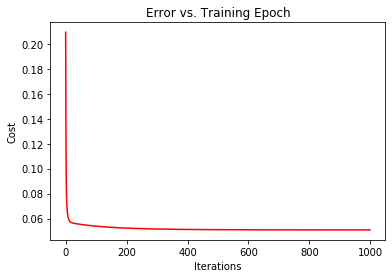

In [1766]:
fig, ax = plt.subplots()  
ax.plot(np.arange(iters), cost, 'r')  
ax.set_xlabel('Iterations')  
ax.set_ylabel('Cost')  
ax.set_title('Error vs. Training Epoch')  

In [1767]:
thetas_lst = g.tolist()[0]
thetas_lst.insert(0,input_state)
thetas_lst

['Wisconsin',
 -1.6278645098566353e-16,
 -0.6890328726149324,
 0.1328985444243027,
 -0.03604138461204874,
 0.072084256796132,
 0.009719490220625541,
 -0.5732488491194949,
 0.934716771234186]

In [1768]:
columns=['state','y_intercept', 'theta_retail', 'theta_grocery',' theta_parks', 'theta_transit','theta_work','theta_home','theta_phi']
theta_df = pd.DataFrame(columns=columns)

In [1769]:
thetas_dict = dict(zip(columns, thetas_lst))
thetas_dict

{'state': 'Wisconsin',
 'y_intercept': -1.6278645098566353e-16,
 'theta_retail': -0.6890328726149324,
 'theta_grocery': 0.1328985444243027,
 ' theta_parks': -0.03604138461204874,
 'theta_transit': 0.072084256796132,
 'theta_work': 0.009719490220625541,
 'theta_home': -0.5732488491194949,
 'theta_phi': 0.934716771234186}

In [1770]:
theta_df = theta_df.append(thetas_dict, ignore_index=True)

In [1771]:
df_gmd_and_infections_no_date.head(3)

,retail_weekly_change,grocery_weekly_change,parks_weekly_change,transit_weekly_change,work_weekly_change,home_weekly_change,phi,est_inf_per_100k
0,32.0,94.0,211.0,20.0,11.0,5.0,0.000101,108.597195
1,-196.0,45.0,108.0,-138.0,-146.0,77.0,0.001086,290.445542
2,-345.0,-139.0,159.0,-269.0,-266.0,125.0,0.002904,232.359869


In [1772]:
input_state

'Wisconsin'

In [1773]:
columns = ['state','retail_weekly_change','grocery_weekly_change','parks_weekly_change','transit_weekly_change',
           'work_weekly_change','home_weekly_change','phi','est_inf_per_100k']

In [1774]:
model_data_means_series = df_gmd_and_infections_no_date.mean(axis=0)
model_data_means_lst = model_data_means_series.tolist()
model_data_means_lst.insert(0,input_state)
model_data_means_dic = dict(zip(columns,model_data_means_lst))
df_model_means = pd.DataFrame(columns=columns)
df_model_means.append(model_data_means_dic, ignore_index=True)

,state,retail_weekly_change,grocery_weekly_change,parks_weekly_change,transit_weekly_change,work_weekly_change,home_weekly_change,phi,est_inf_per_100k
0,Wisconsin,-119.75,1.775,917.775,-108.35,-185.45,63.775,0.003587,379.891382


In [1775]:
model_data_std_series = df_gmd_and_infections_no_date.std(axis=0)
model_data_std_lst = model_data_std_series.tolist()
model_data_std_lst.insert(0,input_state)
model_data_std_dic = dict(zip(columns,model_data_std_lst))
df_model_std = pd.DataFrame(columns=columns)
df_model_std.append(model_data_std_dic, ignore_index=True)

,state,retail_weekly_change,grocery_weekly_change,parks_weekly_change,transit_weekly_change,work_weekly_change,home_weekly_change,phi,est_inf_per_100k
0,Wisconsin,98.68228,61.52735,619.048504,84.988853,59.444846,30.448348,0.003375,341.597024


In [1776]:
# DF of the input features (GMD 0-6 and phi)
test_df = pd.DataFrame(X[:,1:8])

In [1777]:
theta_df.iloc[0,1:9]

y_intercept     -1.62786e-16
theta_retail       -0.689033
theta_grocery       0.132899
 theta_parks      -0.0360414
theta_transit      0.0720843
theta_work        0.00971949
theta_home         -0.573249
theta_phi           0.934717
Name: 0, dtype: object

In [1778]:
ones = np.ones([test_df.shape[0],1])
test_df = np.concatenate((ones,test_df),axis=1)

In [1779]:
test_df = pd.DataFrame(test_df)
test_df.head(2)

,0,1,2,3,4,5,6,7
0,1.0,1.537763,1.498927,-1.141712,1.510198,3.304744,-1.930318,-1.032951
1,1.0,-0.772682,0.702533,-1.308096,-0.348869,0.663640,0.434342,-0.741120


In [1780]:
test1 = theta_df.iloc[0,1:9].to_numpy()

In [1781]:
type(test1)

numpy.ndarray

In [1782]:
print(test_df.shape)
print(test1.shape)

(40, 8)
(8,)


In [1783]:
hyp_df = pd.DataFrame(test_df.dot(test1))

In [1784]:
hyp_df.head(2)

,0
0,-0.537197
1,-0.287507


In [1785]:
hyp_df['y'] = y

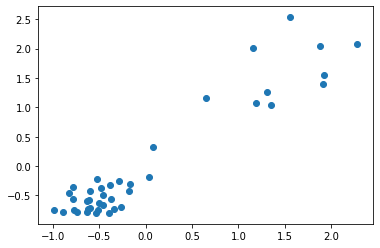

In [1786]:
plt.scatter(hyp_df.iloc[:,0], hyp_df.iloc[0:,1])

<Figure size 432x288 with 0 Axes>

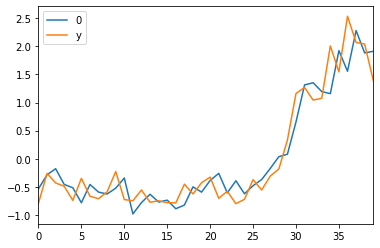

In [1787]:
plt.figure(); hyp_df.plot(); plt.legend(loc='best')

In [1788]:
# df_gmd_and_infections_no_date_normalized = (df_gmd_and_infections_no_date - df_gmd_and_infections_no_date.mean())/df_gmd_and_infections_no_date.std()